# Setup

In [58]:
# !pip install scikit-learn
# !pip install numpy
# !pip install scipy
# !pip install sysidentpy
# !pip install matplotlib==3.1.3
# !pip install catboost

https://sysidentpy.org/

This notebook will attempt to predict the apect ratio and the centriod location of an island overtime

responses to predict:

aspect ratio          ---  inputs: aspect ratio, current magnitude, current direction
centroid x component  ---  inputs: centriod x component, current magnitude, current direction
centroid y component  ---  inputs: centriod y component, current magnitude, current direction


# NARX with exogenous inputs

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data,get_miso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor

In [60]:
# load csv with pandas
aspects = pd.read_csv('../toy_island/100_aspect_ratios.csv')

currents = pd.read_csv('../toy_island/100_current_vectors.csv')


Set up the training and testing data

In [61]:
#setup up variables for training
X = np.array(aspects)[:99]#input is first 99 rows
y = np.array(aspects)[1:]#output is last 99 rows so predicting 1 step ahead

#split data into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid,y_train, y_valid = train_test_split(X, y, train_size=80, test_size=18, shuffle=False, random_state=None)

In [62]:
from sysidentpy.general_estimators import NARX
from sysidentpy.metrics import mean_squared_error
basis_function = Fourier(degree=1)

catboost_narx = NARX(
    base_estimator=CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=8
        ),
    xlag=4,
    ylag=4,
    basis_function=basis_function,
    model_type="NARMAX",
    fit_params={'verbose': False}
)

In [63]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_terms=10,
    extended_least_squares=False,
    ylag=3, xlag=3,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

In [64]:
model.fit(X=x_train, y=y_train)

0.8394035881021044
      Regressors   Parameters             ERR
0         y(k-1)   7.8726E-01  9.87346516E-01
1       y(k-1)^2   2.4975E-01  2.14396764E-03
2         y(k-3)   4.5295E-01  6.08819296E-04
3              1  -5.4683E-01  9.87655567E-05
4   y(k-3)y(k-1)  -3.3298E-01  1.48208251E-04
5      x1(k-3)^2  -1.3039E-01  5.57263755E-05
6  x1(k-3)y(k-1)   6.3629E-01  1.71436500E-04
7        x1(k-3)  -7.0392E-01  5.93879828E-05
8   y(k-2)y(k-1)  -8.3101E-01  4.79808817E-06
9        x1(k-1)   1.5217E+00  2.65109049E-04


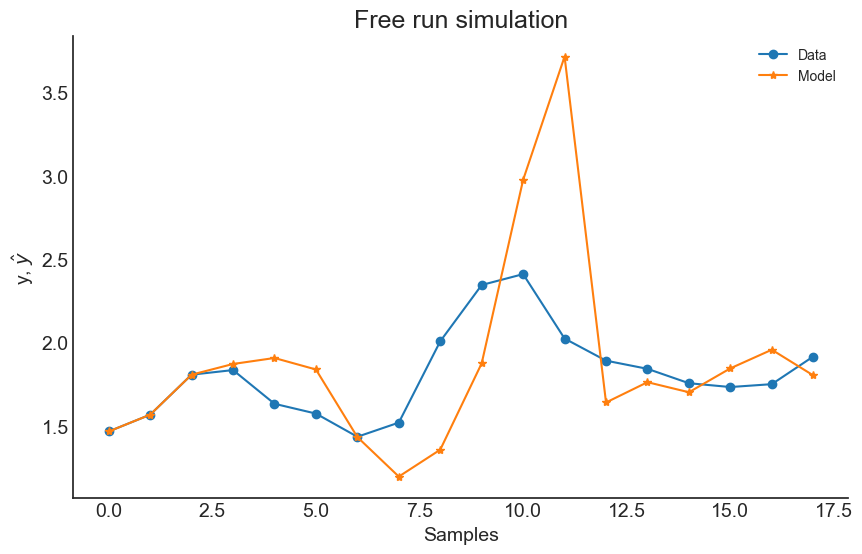

In [65]:
#predicting 10 time steps ahead
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=10)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

0.8957539031027829
      Regressors   Parameters             ERR
0         y(k-1)   7.8726E-01  9.87346516E-01
1       y(k-1)^2   2.4975E-01  2.14396764E-03
2         y(k-3)   4.5295E-01  6.08819296E-04
3              1  -5.4683E-01  9.87655567E-05
4   y(k-3)y(k-1)  -3.3298E-01  1.48208251E-04
5      x1(k-3)^2  -1.3039E-01  5.57263755E-05
6  x1(k-3)y(k-1)   6.3629E-01  1.71436500E-04
7        x1(k-3)  -7.0392E-01  5.93879828E-05
8   y(k-2)y(k-1)  -8.3101E-01  4.79808817E-06
9        x1(k-1)   1.5217E+00  2.65109049E-04


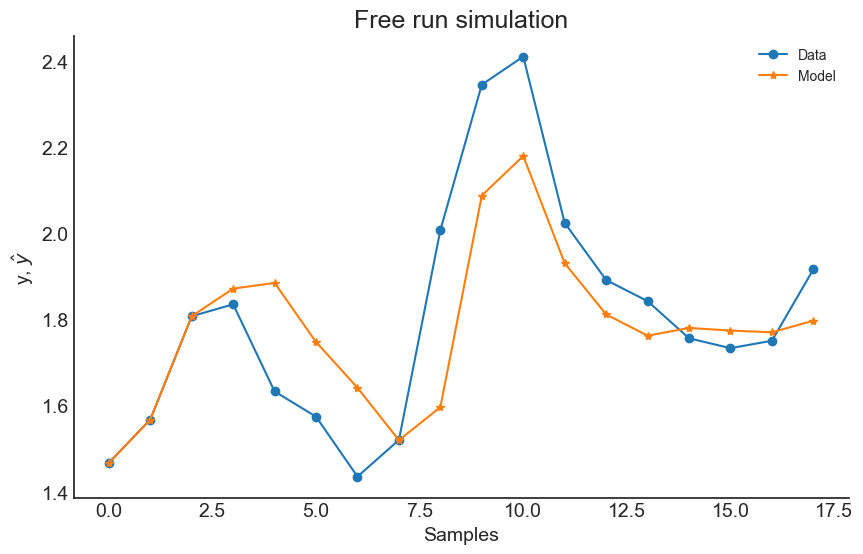

In [66]:
#predicting 1 timestep ahead (much easier for network)
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=1)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

In [67]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sysidentpy.metrics import mean_squared_error
# from sysidentpy.utils.generate_data import get_siso_data,get_miso_data

# # Generate a dataset of a simulated dynamical system
# x_train, x_valid, y_train, y_valid = get_miso_data(
#     n=1000,
#     colored_noise=False,
#     sigma=0.001,
#     train_percentage=80
# )
# x_train.shape

# basis_function = Polynomial(degree=2)


# from torch import nn
# from sysidentpy.neural_network import NARXNN
# from sysidentpy.basis_function._basis_function import Polynomial
# from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
# from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation


# class NARX(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(4, 10)
#         self.lin2 = nn.Linear(10, 10)
#         self.lin3 = nn.Linear(10, 1)
#         self.tanh = nn.Tanh()

#     def forward(self, xb):
#         z = self.lin(xb)
#         z = self.tanh(z)
#         z = self.lin2(z)
#         z = self.tanh(z)
#         z = self.lin3(z)
#         return z

# basis_function=Polynomial(degree=1)

# narx_net = NARXNN(
#     net=NARX(),
#     ylag=2,
#     xlag=[[1],[1]],
#     basis_function=basis_function,
#     model_type="NARMAX",
#     loss_func='mse_loss',
#     optimizer='Adam',
#     epochs=200,
#     verbose=False,
#     optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
# )

# narx_net.fit(X=x_train, y=y_train)
# yhat = narx_net.predict(X=x_valid, y=y_valid)
# plot_results(y=y_valid, yhat=yhat, n=200)
